In [1]:
import json
import os
from google.cloud import storage

# Set up directories and Google Cloud Storage client
bucket_name = "python-dep-graphs"
prefix = "raw_data/codesearchnet"
local_dir = "/kaggle/working/local_codesearchnet_data"
os.makedirs(local_dir, exist_ok=True)

# Initialize Google Cloud Storage client
client = storage.Client.from_service_account_json("/kaggle/input/gcs-secrets/arctic-sentry-453506-t8-ad68857361a1.json")
blobs = client.list_blobs(bucket_name, prefix=prefix)


In [ ]:
# Limit the number of samples to 5000
downloaded = 0
for blob in blobs:
    if downloaded >= 15000:
        break
    if blob.name.endswith(".json") or blob.name.endswith(".jsonl"):
        dest_path = os.path.join(local_dir, os.path.basename(blob.name))
        blob.download_to_filename(dest_path)
        print(f"Downloaded {blob.name} → {dest_path}")
        downloaded += 1


Downloaded raw_data/codesearchnet/entry_0.json → /kaggle/working/local_codesearchnet_data/entry_0.json
Downloaded raw_data/codesearchnet/entry_1.json → /kaggle/working/local_codesearchnet_data/entry_1.json
Downloaded raw_data/codesearchnet/entry_10.json → /kaggle/working/local_codesearchnet_data/entry_10.json
Downloaded raw_data/codesearchnet/entry_100.json → /kaggle/working/local_codesearchnet_data/entry_100.json
Downloaded raw_data/codesearchnet/entry_1000.json → /kaggle/working/local_codesearchnet_data/entry_1000.json
Downloaded raw_data/codesearchnet/entry_10000.json → /kaggle/working/local_codesearchnet_data/entry_10000.json
Downloaded raw_data/codesearchnet/entry_10001.json → /kaggle/working/local_codesearchnet_data/entry_10001.json
Downloaded raw_data/codesearchnet/entry_10002.json → /kaggle/working/local_codesearchnet_data/entry_10002.json
Downloaded raw_data/codesearchnet/entry_10003.json → /kaggle/working/local_codesearchnet_data/entry_10003.json
Downloaded raw_data/codesearc

In [3]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from collections import Counter


In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:



    # 1. DATA PREPARATION
    class CodeSearchNetDataset(Dataset):
        def __init__(self, code_texts, docstrings, code_tokenizer, doc_tokenizer, code_max_len=512, doc_max_len=128):
            self.code_texts = code_texts
            self.docstrings = docstrings
            self.code_tokenizer = code_tokenizer
            self.doc_tokenizer = doc_tokenizer
            self.code_max_len = code_max_len
            self.doc_max_len = doc_max_len
            
        def __len__(self):
            return len(self.code_texts)
        
        def __getitem__(self, idx):
            code = self.code_texts[idx]
            docstring = self.docstrings[idx]
            
            # Tokenize and pad/truncate
            code_tokens = self.code_tokenizer.encode(code, max_length=self.code_max_len)
            doc_tokens = self.doc_tokenizer.encode(docstring, max_length=self.doc_max_len)
            
            return {
                'code_ids': torch.tensor(code_tokens, dtype=torch.long),
                'doc_ids': torch.tensor(doc_tokens, dtype=torch.long),
                'code_length': len(code_tokens),
                'doc_length': len(doc_tokens)
            }

    class SimpleTokenizer:
        def __init__(self, texts=None, vocab_size=10000, min_freq=2):
            self.vocab_size = vocab_size
            self.min_freq = min_freq
            self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
            self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<SOS>', 3: '<EOS>'}
            self.word_freq = Counter()
            
            if texts:
                self.fit(texts)
        
        def tokenize(self, text):
            # Simple tokenization by splitting on whitespace and removing special chars
            text = re.sub(r'[^\w\s]', ' ', text.lower())
            return text.split()
        
        def fit(self, texts):
        
            for text in texts:
                self.word_freq.update(self.tokenize(text))
            
        
            words = [word for word, count in self.word_freq.items() 
                    if count >= self.min_freq]
            
        
            words = sorted(words, key=lambda x: self.word_freq[x], reverse=True)[:self.vocab_size - 4]
            
        
            for i, word in enumerate(words):
                idx = i + 4 
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        
        def encode(self, text, max_length=None):
            tokens = [self.word2idx.get(word, self.word2idx['<UNK>']) 
                    for word in self.tokenize(text)]
            
        
            tokens = [self.word2idx['<SOS>']] + tokens + [self.word2idx['<EOS>']]
            
        
            if max_length:
                if len(tokens) > max_length:
                    tokens = tokens[:max_length]
                else:
                    tokens += [self.word2idx['<PAD>']] * (max_length - len(tokens))
            
            return tokens
        
        def decode(self, ids):
            return ' '.join([self.idx2word.get(idx, '<UNK>') for idx in ids])
        
        def vocab_size(self):
            return len(self.word2idx)

In [6]:


# Function to load and preprocess the data
def load_data(data_dir, max_samples=None):
    code_texts = []
    docstrings = []
    
    file_count = 0
    for filename in os.listdir(data_dir):
        if filename.endswith('.json') or filename.endswith('.jsonl'):
            file_path = os.path.join(data_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    try:
                        data = json.loads(line)
                        # Extract code and docstring
                        code = data.get('code', '')
                        docstring = data.get('docstring', '')
                        
                        # Skip empty entries
                        if not code or not docstring:
                            continue
                            
                        code_texts.append(code)
                        docstrings.append(docstring)
                        
                        if max_samples and len(code_texts) >= max_samples:
                            return code_texts, docstrings
                    except json.JSONDecodeError:
                        continue
            file_count += 1
            print(f"Processed {file_count} files, loaded {len(code_texts)} samples")
    
    return code_texts, docstrings


In [ ]:

# 2. MODEL ARCHITECTURE

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register buffer (won't be updated during backprop)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # Add positional encoding to input
        return x + self.pe[:, :x.size(1)]

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Linear layers for Q, K, V
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        
        self.out = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        
        # Linear projections and reshape for multi-head
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
       
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        
      
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        
        attention = torch.softmax(scores, dim=-1)
        
       
        out = torch.matmul(attention, v)
        
      
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.out(out)

# Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
      
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

# Complete Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout=0.1):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
        
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
       
        x = self.embedding(x) * np.sqrt(self.embedding.embedding_dim)
        
       
        x = self.pos_encoding(x)
     
        x = self.dropout(x)
        
       
        for layer in self.layers:
            x = layer(x, mask)
        
        
        return self.norm(x)

# Code-Docstring Transformer Model
class CodeDocTransformer(nn.Module):
    def __init__(self, code_vocab_size, doc_vocab_size, d_model=256, num_heads=8, 
                 num_layers=3, d_ff=512, max_seq_len=512, dropout=0.1):
        super(CodeDocTransformer, self).__init__()
        
        # Code and docstring encoders
        self.code_encoder = Encoder(code_vocab_size, d_model, num_heads, num_layers, 
                                   d_ff, max_seq_len, dropout)
        self.doc_encoder = Encoder(doc_vocab_size, d_model, num_heads, num_layers, 
                                  d_ff, max_seq_len, dropout)
        
        
        self.code_projection = nn.Linear(d_model, d_model)
        self.doc_projection = nn.Linear(d_model, d_model)
        
    def forward(self, code_ids, doc_ids, code_mask=None, doc_mask=None):
        
        code_encoded = self.code_encoder(code_ids, code_mask)
        doc_encoded = self.doc_encoder(doc_ids, doc_mask)
        
        
        code_repr = code_encoded.mean(dim=1)
        doc_repr = doc_encoded.mean(dim=1)
        
        
        code_proj = self.code_projection(code_repr)
        doc_proj = self.doc_projection(doc_repr)
        
        return code_proj, doc_proj

In [ ]:


# 3. TRAINING FUNCTIONS

# Calculate cosine similarity matrix between code and docstring embeddings
def calculate_similarity(code_embeds, doc_embeds):
   
    code_embeds_norm = code_embeds / code_embeds.norm(dim=1, keepdim=True)
    doc_embeds_norm = doc_embeds / doc_embeds.norm(dim=1, keepdim=True)
    
   
    return torch.matmul(code_embeds_norm, doc_embeds_norm.transpose(0, 1))


def contrastive_loss(similarity, temperature=0.1):
   
    batch_size = similarity.size(0)
    targets = torch.arange(batch_size).to(similarity.device)
   
    similarity = similarity / temperature
    
    
    loss_code_to_doc = nn.CrossEntropyLoss()(similarity, targets)
    loss_doc_to_code = nn.CrossEntropyLoss()(similarity.t(), targets)
    
    return (loss_code_to_doc + loss_doc_to_code) / 2


In [ ]:

# Calculate accuracy
def calculate_accuracy(similarity):
   
    _, predicted_idx = similarity.max(dim=1)
    correct = (predicted_idx == torch.arange(similarity.size(0)).to(similarity.device)).sum()
    return correct / similarity.size(0)

# Training loop
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    
    for batch in tqdm(dataloader, desc="Training"):
       
        code_ids = batch['code_ids'].to(device)
        doc_ids = batch['doc_ids'].to(device)
        
       
        code_embeds, doc_embeds = model(code_ids, doc_ids)
        
       
        similarity = calculate_similarity(code_embeds, doc_embeds)
        loss = contrastive_loss(similarity)
        
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
       
        acc = calculate_accuracy(similarity)
        
        
        total_loss += loss.item()
        total_acc += acc.item()
    
    return total_loss / len(dataloader), total_acc / len(dataloader)


In [ ]:

# Validation loop
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            
            code_ids = batch['code_ids'].to(device)
            doc_ids = batch['doc_ids'].to(device)
            
           
            code_embeds, doc_embeds = model(code_ids, doc_ids)
            
            
            similarity = calculate_similarity(code_embeds, doc_embeds)
            loss = contrastive_loss(similarity)
            
            
            acc = calculate_accuracy(similarity)
            
            
            total_loss += loss.item()
            total_acc += acc.item()
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:


def load_model(load_dir="/kaggle/working/code_transformer_export", device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Load a previously saved model and tokenizers
    """
    import os
    import pickle
    import torch
    
   
    with open(os.path.join(load_dir, "model_config.pkl"), 'rb') as f:
        model_config = pickle.load(f)
    
  
    model = CodeDocTransformer(
        code_vocab_size=model_config['code_vocab_size'],
        doc_vocab_size=model_config['doc_vocab_size'],
        d_model=model_config['d_model'],
        num_heads=model_config['num_heads'],
        num_layers=model_config['num_layers'],
        d_ff=model_config['d_ff'],
        max_seq_len=model_config['max_seq_len'],
        dropout=model_config['dropout']
    ).to(device)
    
 
    model.load_state_dict(torch.load(os.path.join(load_dir, "model_state_dict.pt"), map_location=device))
    
   
    with open(os.path.join(load_dir, "code_tokenizer.pkl"), 'rb') as f:
        code_tokenizer = pickle.load(f)
    
    with open(os.path.join(load_dir, "doc_tokenizer.pkl"), 'rb') as f:
        doc_tokenizer = pickle.load(f)
    
    print(f"Model and tokenizers loaded from {load_dir}")
    return model, code_tokenizer, doc_tokenizer


In [ ]:





def save_and_export_model(model, code_tokenizer, doc_tokenizer, save_dir="/kaggle/working/code_transformer_export"):
    """
    Save the model and tokenizers for later use
    """
    import os
    import pickle
    import torch
    
   
    os.makedirs(save_dir, exist_ok=True)
    
    
    torch.save(model.state_dict(), os.path.join(save_dir, "model_state_dict.pt"))
    
    
    model_config = {
        'code_vocab_size': len(code_tokenizer.word2idx),
        'doc_vocab_size': len(doc_tokenizer.word2idx),
        'd_model': model.code_encoder.embedding.embedding_dim,
        'num_heads': model.code_encoder.layers[0].self_attn.num_heads,
        'num_layers': len(model.code_encoder.layers),
        'd_ff': model.code_encoder.layers[0].feed_forward.linear1.out_features,
        'max_seq_len': model.code_encoder.pos_encoding.pe.shape[1],
        'dropout': model.code_encoder.dropout.p
    }
    
    with open(os.path.join(save_dir, "model_config.pkl"), 'wb') as f:
        pickle.dump(model_config, f)
    
    
    with open(os.path.join(save_dir, "code_tokenizer.pkl"), 'wb') as f:
        pickle.dump(code_tokenizer, f)
    
    with open(os.path.join(save_dir, "doc_tokenizer.pkl"), 'wb') as f:
        pickle.dump(doc_tokenizer, f)
    
   
    try:
        
        dummy_code_ids = torch.ones(1, 128, dtype=torch.long).to(device)
        dummy_doc_ids = torch.ones(1, 64, dtype=torch.long).to(device)
        
        l
        torch.onnx.export(
            model,
            (dummy_code_ids, dummy_doc_ids),
            os.path.join(save_dir, "code_transformer.onnx"),
            export_params=True,
            opset_version=12,
            do_constant_folding=True,
            input_names=['code_ids', 'doc_ids'],
            output_names=['code_embeddings', 'doc_embeddings'],
            dynamic_axes={
                'code_ids': {0: 'batch_size', 1: 'code_seq_length'},
                'doc_ids': {0: 'batch_size', 1: 'doc_seq_length'},
                'code_embeddings': {0: 'batch_size'},
                'doc_embeddings': {0: 'batch_size'}
            }
        )
        print("ONNX export successful")
    except Exception as e:
        print(f"ONNX export failed: {e}")
    
    print(f"Model and tokenizers saved to {save_dir}")
    return save_dir


In [ ]:



def search_code_by_query(model, query, code_corpus, doc_tokenizer, code_tokenizer, top_k=5, device=device):
    model.eval()
    
   
    query_tokens = doc_tokenizer.encode(query, max_length=128)
    query_tensor = torch.tensor([query_tokens], dtype=torch.long).to(device)
    
    
    code_tensors = []
    for code in code_corpus:
        code_tokens = code_tokenizer.encode(code, max_length=512)
        code_tensors.append(torch.tensor(code_tokens, dtype=torch.long))
    
    code_batch = torch.nn.utils.rnn.pad_sequence(code_tensors, batch_first=True).to(device)
    
   
    with torch.no_grad():
        _, query_embed = model(code_batch[:1], query_tensor)  # Dummy code input
        code_embed, _ = model(code_batch, query_tensor[:1].repeat(code_batch.size(0), 1))  # Dummy doc input
    
   
    query_embed_norm = query_embed / query_embed.norm(dim=1, keepdim=True)
    code_embed_norm = code_embed / code_embed.norm(dim=1, keepdim=True)
    
    similarities = torch.matmul(query_embed_norm, code_embed_norm.transpose(0, 1)).squeeze(0)
    

    top_indices = similarities.argsort(descending=True)[:top_k]
    
    results = []
    for idx in top_indices:
        results.append({
            'code': code_corpus[idx.item()],
            'similarity': similarities[idx].item()
        })
    
    return results


Loading data...
Processed 1 files, loaded 1 samples
Processed 2 files, loaded 2 samples
Processed 3 files, loaded 3 samples
Processed 4 files, loaded 4 samples
Processed 5 files, loaded 5 samples
Processed 6 files, loaded 6 samples
Processed 7 files, loaded 7 samples
Processed 8 files, loaded 8 samples
Processed 9 files, loaded 9 samples
Processed 10 files, loaded 10 samples
Processed 11 files, loaded 11 samples
Processed 12 files, loaded 12 samples
Processed 13 files, loaded 13 samples
Processed 14 files, loaded 14 samples
Processed 15 files, loaded 15 samples
Processed 16 files, loaded 16 samples
Processed 17 files, loaded 17 samples
Processed 18 files, loaded 18 samples
Processed 19 files, loaded 19 samples
Processed 20 files, loaded 20 samples
Processed 21 files, loaded 21 samples
Processed 22 files, loaded 22 samples
Processed 23 files, loaded 23 samples
Processed 24 files, loaded 24 samples
Processed 25 files, loaded 25 samples
Processed 26 files, loaded 26 samples
Processed 27 f

Validation: 100%|██████████| 16/16 [00:00<00:00, 18.00it/s]


Train Loss: 2.4933, Train Acc: 0.1961
Val Loss: 2.0556, Val Acc: 0.3402

Epoch 2/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.72it/s]


Train Loss: 1.5250, Train Acc: 0.5149
Val Loss: 1.4199, Val Acc: 0.5359

Epoch 3/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.95it/s]


Train Loss: 1.1566, Train Acc: 0.6385
Val Loss: 1.1770, Val Acc: 0.6375

Epoch 4/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.66it/s]


Train Loss: 0.9836, Train Acc: 0.6884
Val Loss: 1.1134, Val Acc: 0.6633

Epoch 5/10


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.96it/s]


Train Loss: 0.8484, Train Acc: 0.7356
Val Loss: 1.0475, Val Acc: 0.7004

Epoch 6/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.55it/s]


Train Loss: 0.7469, Train Acc: 0.7699
Val Loss: 0.9749, Val Acc: 0.7180

Epoch 7/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.26it/s]


Train Loss: 0.6158, Train Acc: 0.8212
Val Loss: 0.8333, Val Acc: 0.7793

Epoch 8/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.44it/s]


Train Loss: 0.5221, Train Acc: 0.8569
Val Loss: 0.7981, Val Acc: 0.7773

Epoch 9/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.31it/s]


Train Loss: 0.4446, Train Acc: 0.8881
Val Loss: 0.7354, Val Acc: 0.8184

Epoch 10/10


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.38it/s]


Train Loss: 0.3838, Train Acc: 0.9112
Val Loss: 0.7094, Val Acc: 0.8066


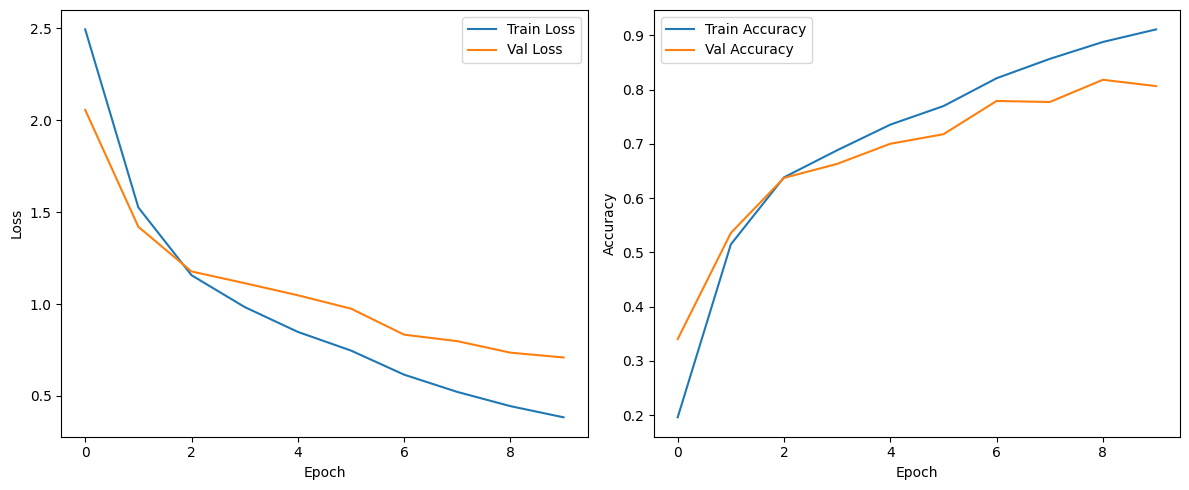

/tmp/ipykernel_31/3931946791.py:50: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))


ONNX export successful
Model and tokenizers saved to /kaggle/working/code_transformer_export
Model and tokenizers loaded from /kaggle/working/code_transformer_export

Testing loaded model...


/tmp/ipykernel_31/3662520867.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(load_dir, "model_state_dict.pt"), map_locatio


Testing code search functionality...
Query: Build an action from a string input

Result 1 (similarity: 0.6097):
Code:
def register_classes(self, classes):
        """
        Register classes as plugins that are not subclassed from
        IPlugin.
        `classes` may be a single object or an iterable.
        """
        classes = util.return_list(classes)
        for klass in classes:
            IPlugin.register(klass)...

Result 2 (similarity: 0.5490):
Code:
def _get(self, url, **kw):
        '''
        Makes a GET request, setting Authorization
        header by default
        '''
        headers = kw.pop('headers', {})
        headers.setdefault('Content-Type', 'application/json')
        headers.setdefault('Accept', 'application/json')
        headers.setdefault('Authorization', self.AUTHORIZATION_HEADER)
        kw['headers'] = headers
        resp = self.session.get(url, **kw)
        self._raise_for_status(resp)
        return resp...

Result 3 (similarity: 0.5184):
Code

In [ ]:

# 4. MAIN TRAINING SCRIPT
def main():
    # Parameters
    data_dir = "/kaggle/working/local_codesearchnet_data"
    max_samples = 15000  # Use all available samples or limit
    batch_size = 32
    epochs = 10
    learning_rate = 0.0001
    code_max_len = 512
    doc_max_len = 128
    d_model = 256
    num_heads = 8
    num_layers = 3
    d_ff = 512
    dropout = 0.1
    
    # Load data
    print("Loading data...")
    code_texts, docstrings = load_data(data_dir, max_samples)
    print(f"Loaded {len(code_texts)} code-docstring pairs")
    
    # Split data
    code_train, code_val, doc_train, doc_val = train_test_split(
        code_texts, docstrings, test_size=0.1, random_state=42
    )
    
    # Create tokenizers
    print("Creating tokenizers...")
    code_tokenizer = SimpleTokenizer(code_train, vocab_size=10000, min_freq=2)
    doc_tokenizer = SimpleTokenizer(doc_train, vocab_size=8000, min_freq=2)
    
    print(f"Code vocabulary size: {len(code_tokenizer.word2idx)}")
    print(f"Docstring vocabulary size: {len(doc_tokenizer.word2idx)}")
    
    # Create datasets
    train_dataset = CodeSearchNetDataset(
        code_train, doc_train, code_tokenizer, doc_tokenizer, 
        code_max_len=code_max_len, doc_max_len=doc_max_len
    )
    
    val_dataset = CodeSearchNetDataset(
        code_val, doc_val, code_tokenizer, doc_tokenizer,
        code_max_len=code_max_len, doc_max_len=doc_max_len
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model
    print("Initializing model...")
    model = CodeDocTransformer(
        code_vocab_size=len(code_tokenizer.word2idx),
        doc_vocab_size=len(doc_tokenizer.word2idx),
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        max_seq_len=max(code_max_len, doc_max_len),
        dropout=dropout
    ).to(device)
    
    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    print("Starting training...")
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f"/kaggle/working/transformer_checkpoint_epoch_{epoch+1}.pt")
    
    # Save final model
    torch.save(model.state_dict(), "/kaggle/working/code_transformer_final.pt")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_curves.png')
    plt.show()

    save_dir = save_and_export_model(model, code_tokenizer, doc_tokenizer)
    
   
    loaded_model, loaded_code_tokenizer, loaded_doc_tokenizer = load_model(save_dir)
  
    print("\nTesting loaded model...")
    query = "Build an action from a string input"
    search_results = search_code_by_query(
        loaded_model, query, code_val[:100], loaded_doc_tokenizer, loaded_code_tokenizer, 
        top_k=3, device=device
    )
    
    
    print("\nTesting code search functionality...")
    query = "Build an action from a string input"
    search_results = search_code_by_query(
        model, query, code_val[:100], doc_tokenizer, code_tokenizer, top_k=3, device=device
    )
    
    print(f"Query: {query}")
    for i, result in enumerate(search_results):
        print(f"\nResult {i+1} (similarity: {result['similarity']:.4f}):")
        print(f"Code:\n{result['code'][:500]}...")
    save_dir = save_and_export_model(model, code_tokenizer, doc_tokenizer)

if __name__ == "__main__":
    main()